## Monetary Policy Shocks

Christiano, Lawrence J., Martin Eichenbaum, and Charles L. Evans. 1999.
"Monetary Policy Shocks: What Have We Learned and to What End?"


In [1]:
%config InlineBackend.figure_format='retina'
from ekorpkit import eKonf

eKonf.setLogger("WARNING")
print("version:", eKonf.__version__)
print("is notebook?", eKonf.is_notebook())
print("is colab?", eKonf.is_colab())
print("evironment varialbles:")
eKonf.print(eKonf.env().dict())

INFO:ekorpkit.base:IPython version: (6, 9, 0), client: jupyter_client
INFO:ekorpkit.base:Google Colab not detected.


version: 0.1.35+0.g69734d6.dirty
is notebook? True
is colab? False
evironment varialbles:
{'CUDA_DEVICE_ORDER': None,
 'CUDA_VISIBLE_DEVICES': None,
 'EKORPKIT_CONFIG_DIR': '/workspace/projects/ekorpkit-book/config',
 'EKORPKIT_DATA_DIR': None,
 'EKORPKIT_LOG_LEVEL': 'WARNING',
 'EKORPKIT_PROJECT': 'ekorpkit-book',
 'EKORPKIT_WORKSPACE_ROOT': '/workspace',
 'KMP_DUPLICATE_LIB_OK': 'TRUE',
 'NUM_WORKERS': 230}


In [2]:
start_year = 1999
data_dir = "../data/fomc"
eKonf.env().FRED_API_KEY


pydantic.types.SecretStr

In [24]:
import numpy as np

ids = {
    "GDPC1": "Real GDP",
    "PCECC96": "Real Consumption",
    "GDPDEF": "GDP Deflator",
    "GPDIC1": "Real investment",
    "COMPRNFB": "Real wage",
    "OPHNFB": "Labor productivity",
    "FEDFUNDS": "Federal funds rate",
    "CP": "Real profit",
    "M2SL": "M2 Growth",
    "SP500": "SP500",
    "CPIAUCSL": "CPI",
}
cols = list(ids.keys())

cfg = eKonf.compose("io/fetcher=quandl")
cfg.series_name = "value"
cfg.series_id = cols
# cfg.force_download = True
quandl = eKonf.instantiate(cfg)

econ_data = quandl.data.reset_index()


cfg = eKonf.compose("pipeline/pivot")
cfg.index = "date"
cfg.columns = "series_id"
cfg.values = ["value"]
econ_data_pivot = eKonf.pipe(econ_data, cfg)


econ_data_pivot = econ_data_pivot.set_index("date").resample("Q").last()
cols.remove("M2SL")
econ_data_pivot[cols] = np.log(econ_data_pivot[cols])
econ_data_pivot["M2SL"] = econ_data_pivot.M2SL.pct_change()
econ_data_pivot


INFO:ekorpkit.base:Applying pipe: functools.partial(<function pivot at 0x7f4a921e4af0>)


series_id,COMPRNFB,CP,CPIAUCSL,FEDFUNDS,GDPC1,GDPDEF,GPDIC1,M2SL,OPHNFB,PCECC96,SP500
date,,,,,,,,,,,
1946-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1946-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1946-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1946-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1947-03-31,3.578618,3.089678,3.091042,NaN,7.617981,2.480899,5.384912,NaN,3.144712,7.152613,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2021-06-30,4.746253,7.897441,5.601953,-2.525729,9.871394,4.765698,8.162235,0.030493,4.723513,9.522638,8.365789
2021-09-30,4.745236,7.908976,5.613909,-2.525729,9.877087,4.780089,8.191378,0.026018,4.713495,9.527514,8.368122
2021-12-31,4.751225,7.901128,5.635240,-2.525729,9.893755,4.797343,8.269513,0.023429,4.728865,9.533753,8.469300


In [31]:
def plot_irfs(
    from_year=1990,
    to_year=2021,
    shock_name="Federal funds rate",
    tone_col=None,
    econ_cols=[
        "COMPRNFB",
        "CP",
        "FEDFUNDS",
        "GDPC1",
        "GDPDEF",
        "GPDIC1",
        "M2SL",
        "OPHNFB",
        "PCECC96",
    ],
):
    _data = econ_data_pivot[
        (econ_data_pivot.index.year >= from_year)
        & (econ_data_pivot.index.year <= to_year)
    ].copy()

    _data = _data[econ_cols]
    _names = {col: ids[col] for col in econ_cols}
    _data.rename(columns=_names, inplace=True)

    if tone_col in fomc_train_tones.columns:
        f_tone_data = fomc_train_tones[[tone_col]].dropna()
        tones_q = f_tone_data.resample("Q").mean()
        _data = _data.merge(
            tones_q[[tone_col]].ffill(), left_index=True, right_index=True
        )

    irfs = fomc.get_irf(_data)
    if shock_name:
        fomc.plot_irf(irfs, shock_name)

    if tone_col in _data.columns:
        fomc.plot_irf(irfs, tone_col)

### Plot impulse response functions


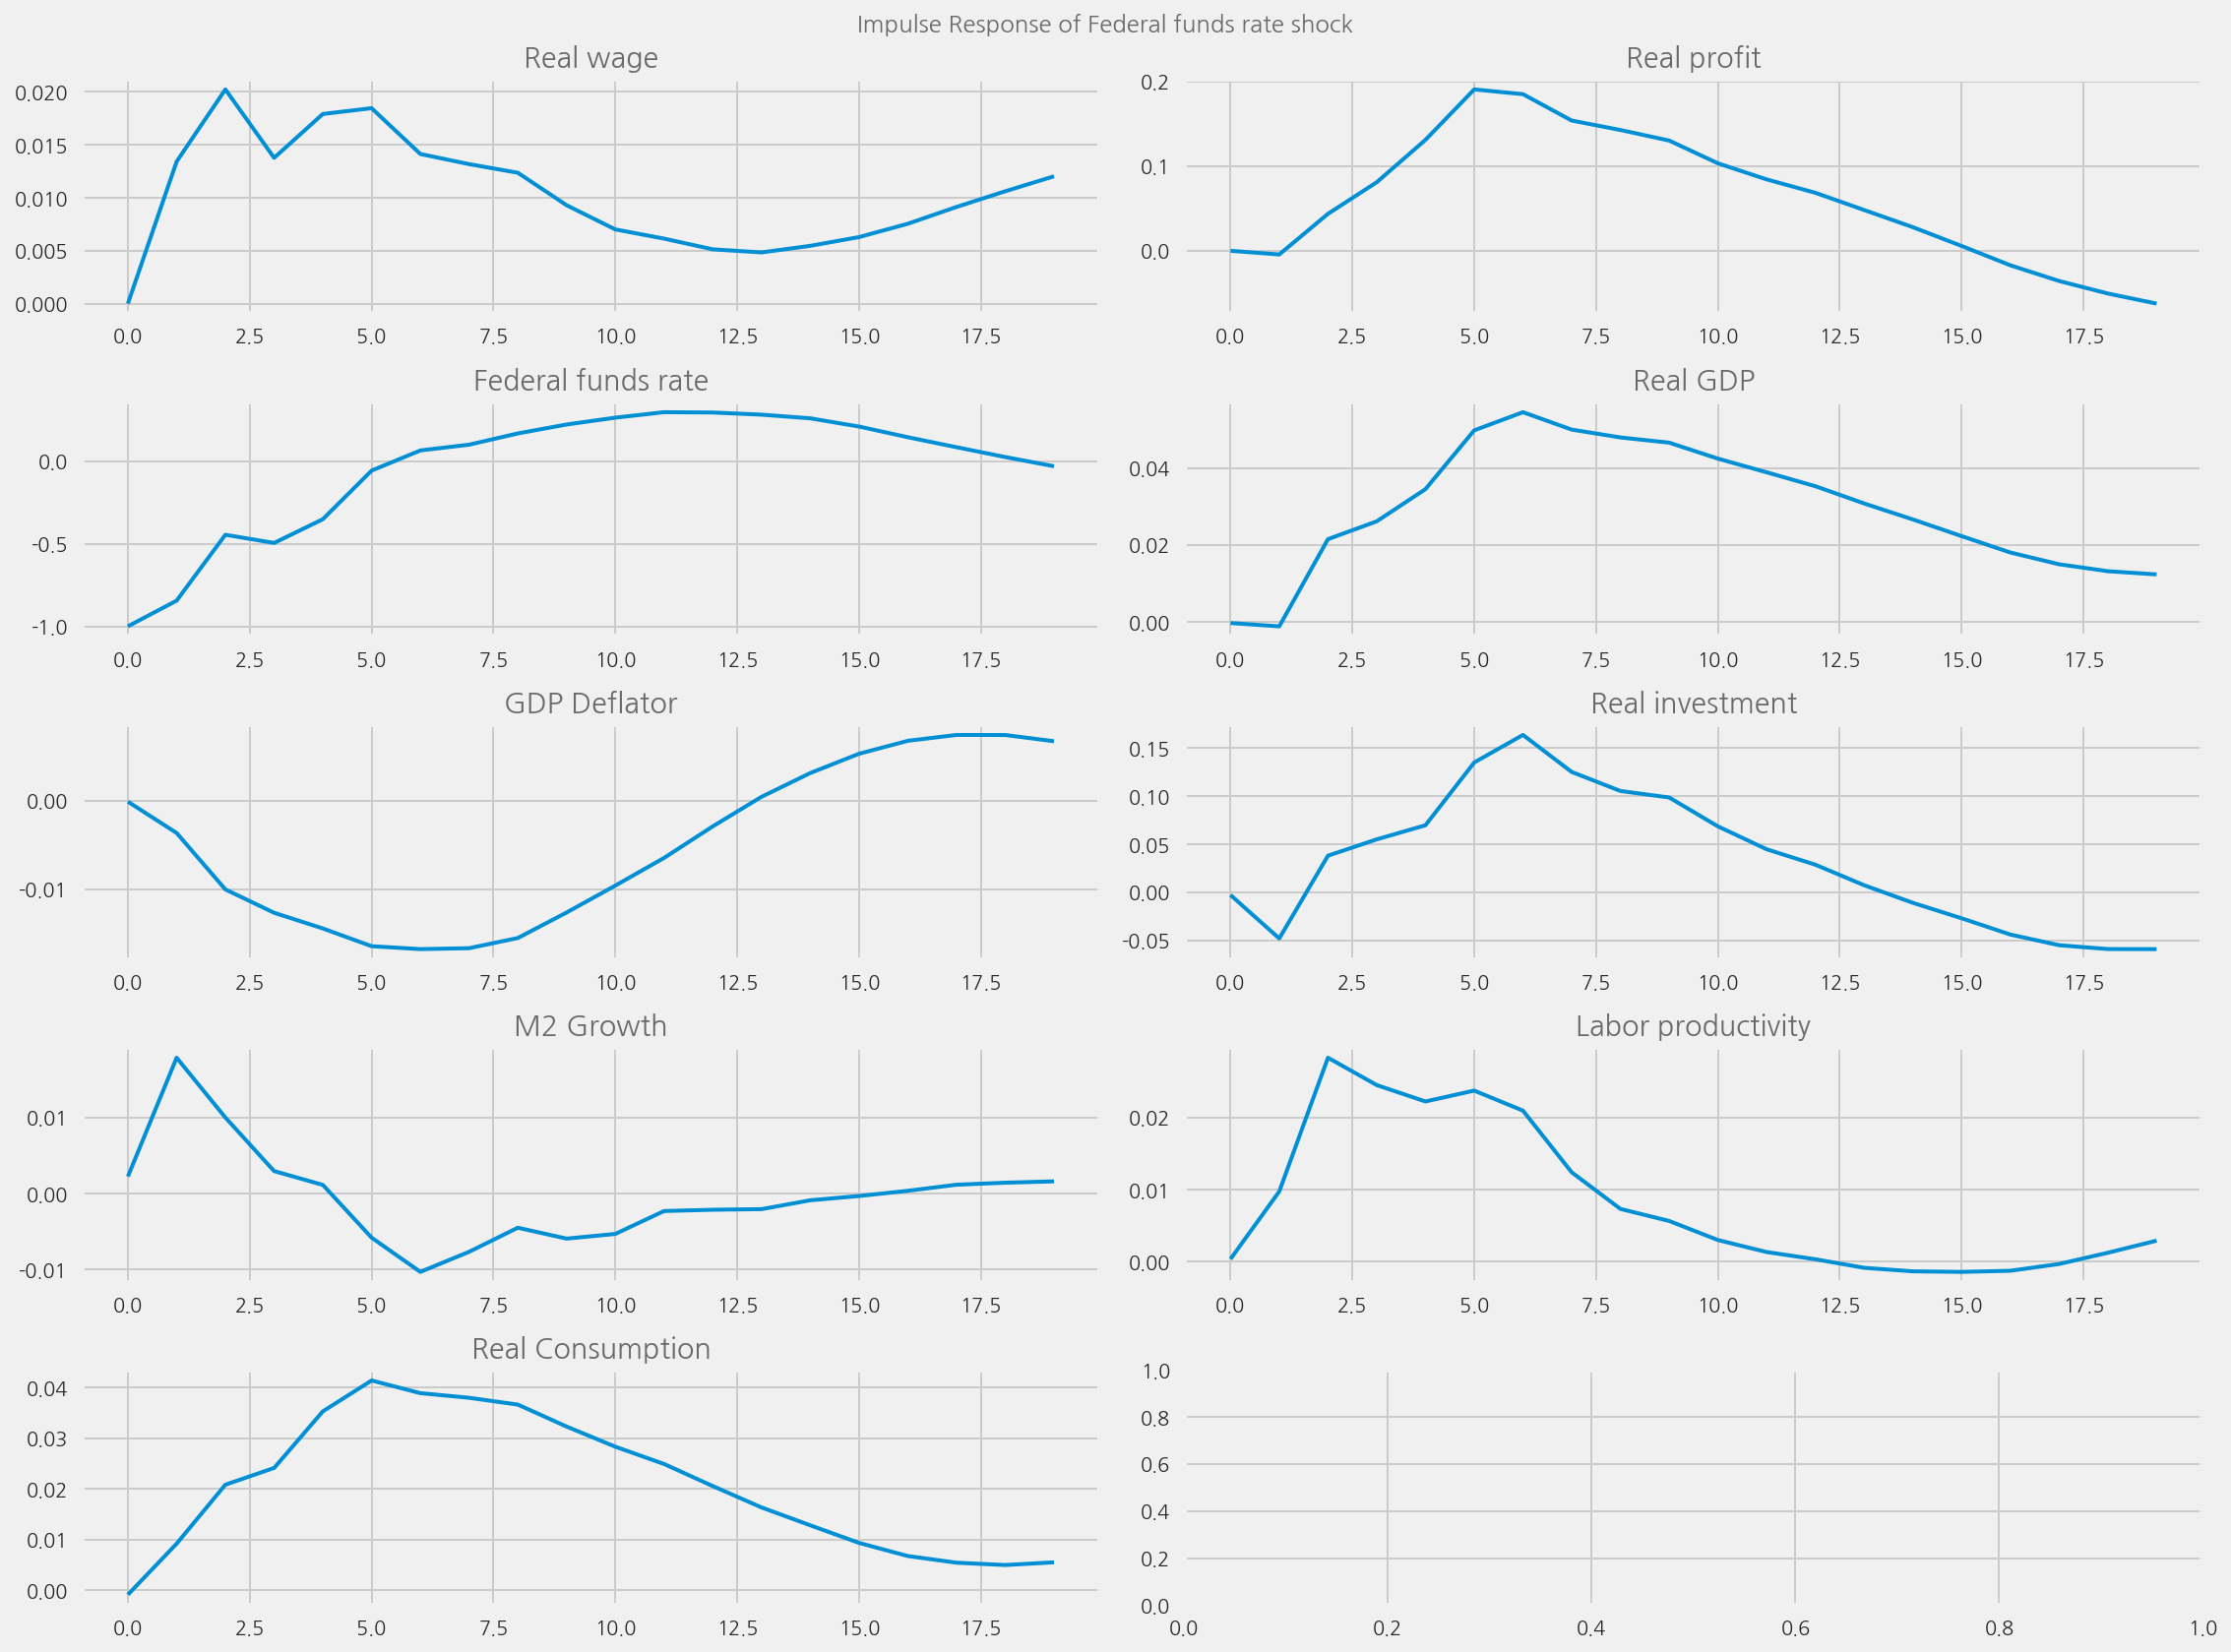

In [26]:
plot_irfs(from_year=1965, to_year=1995)


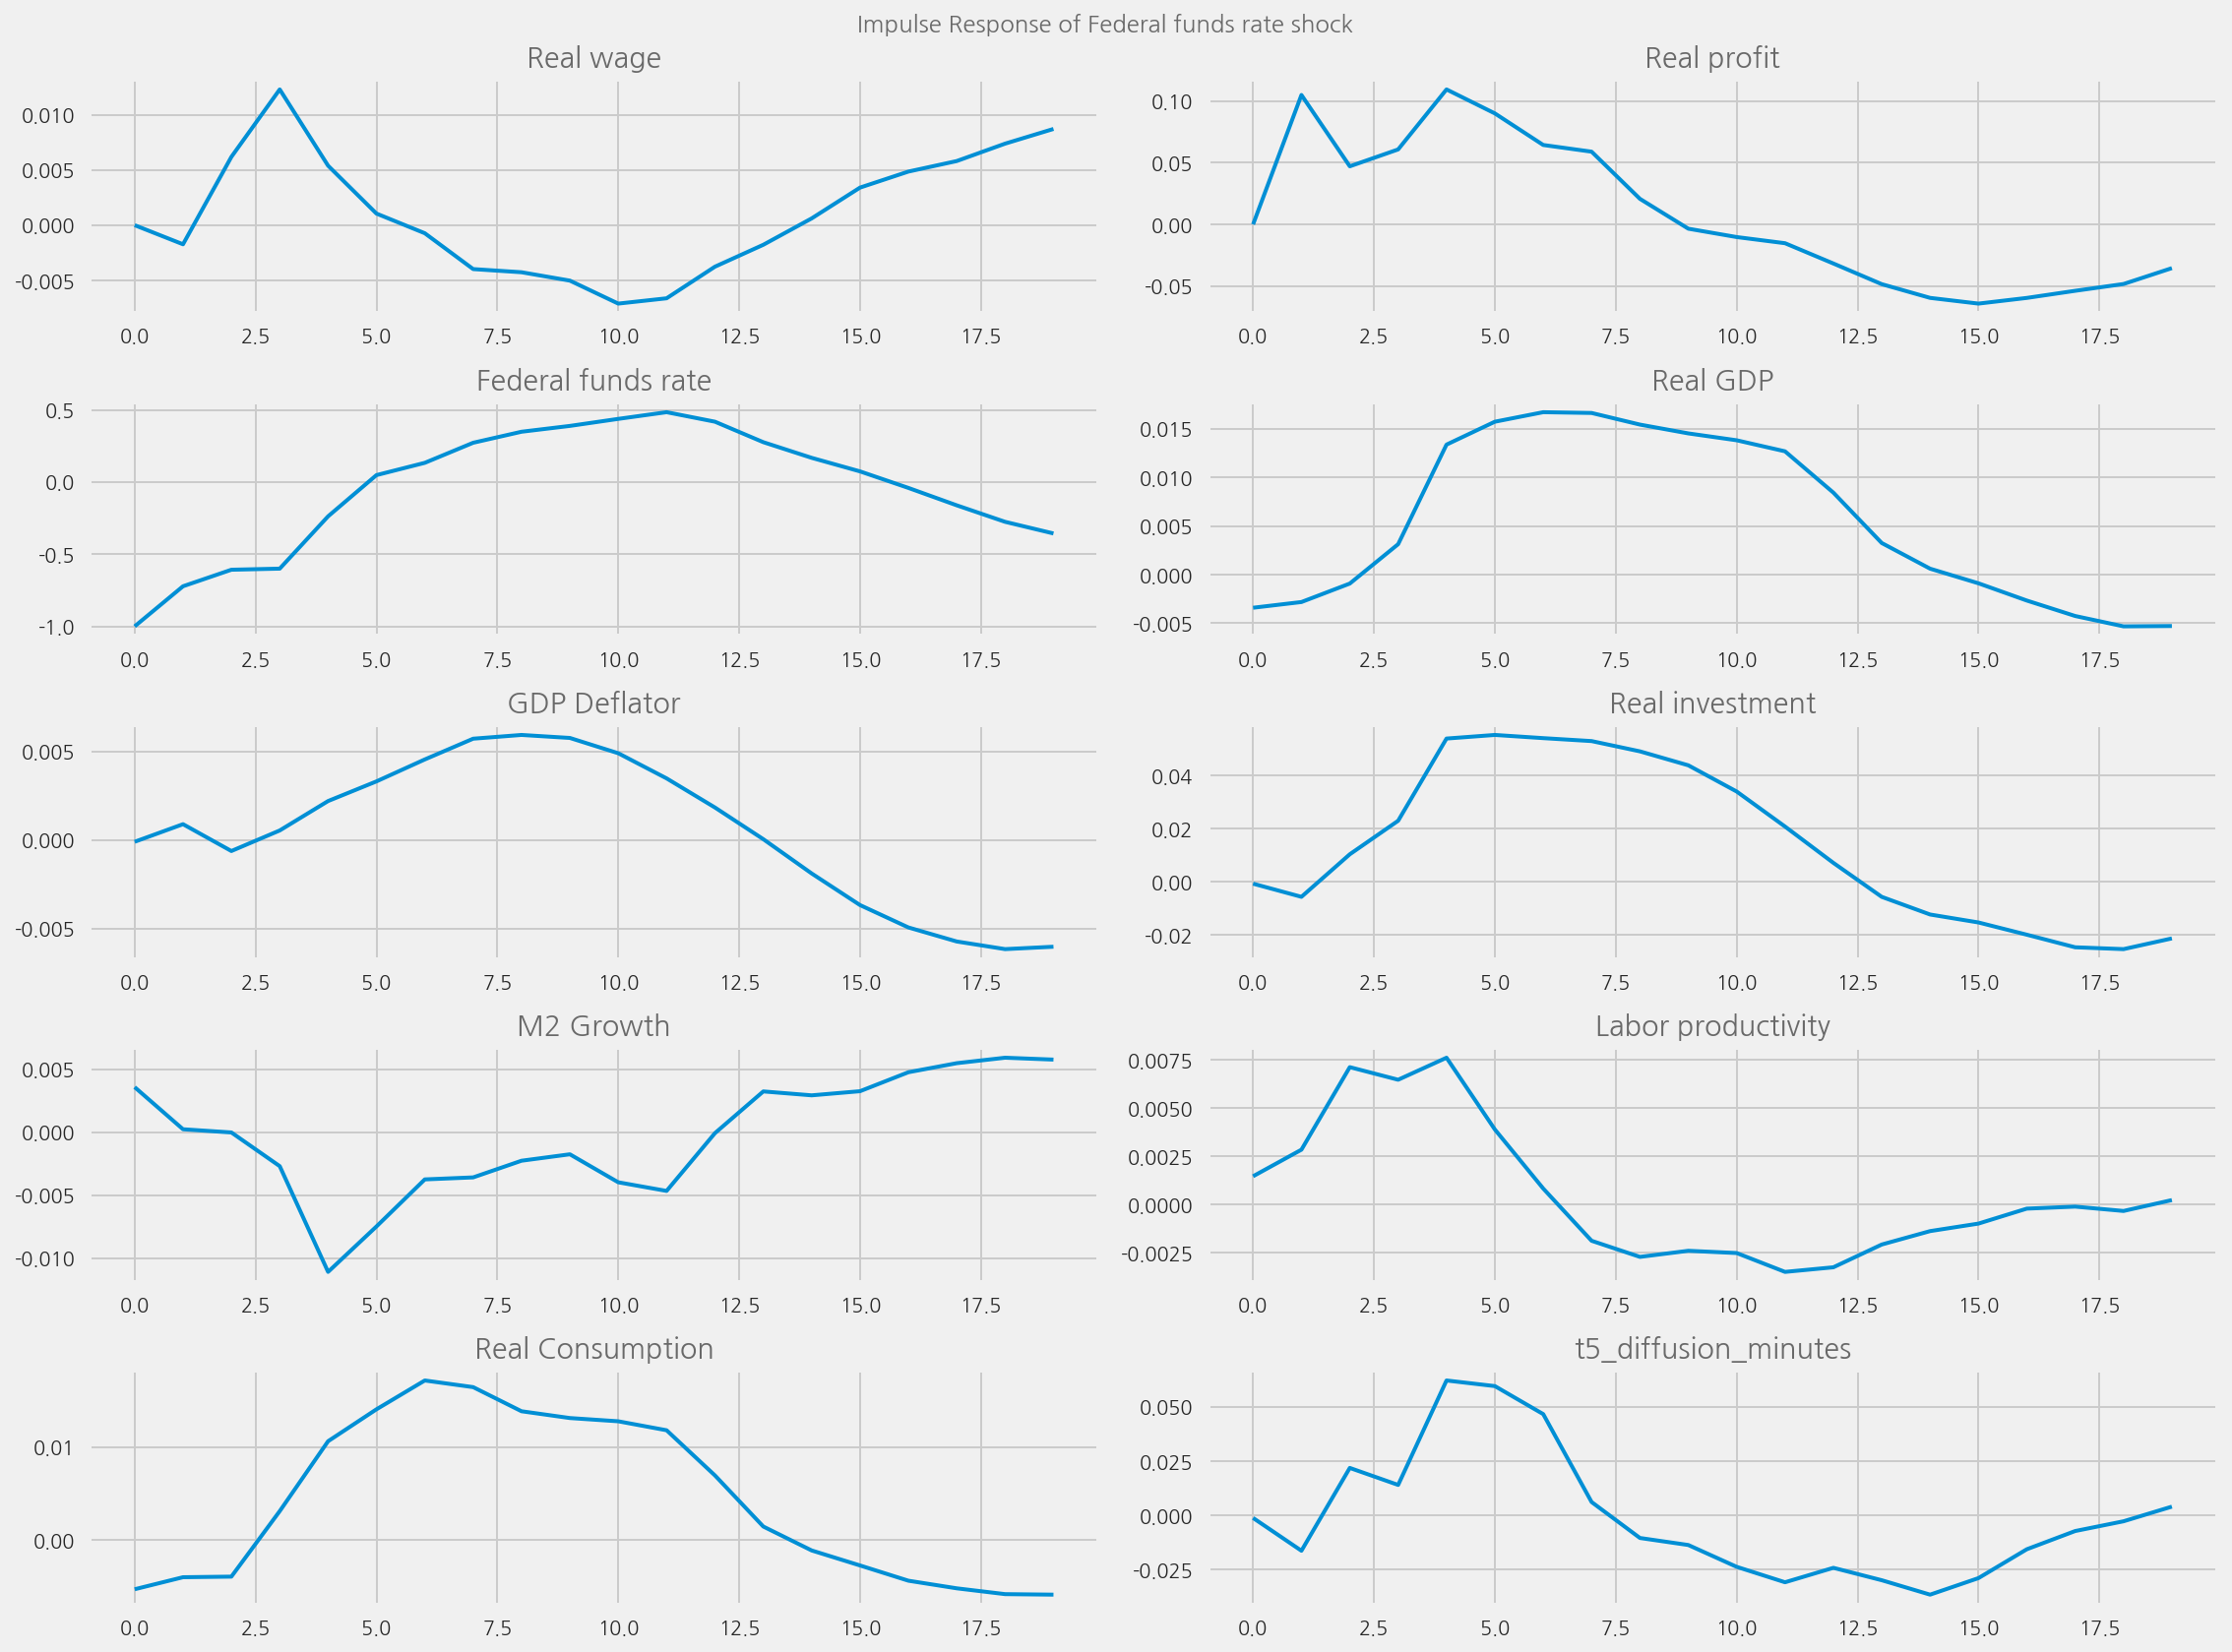

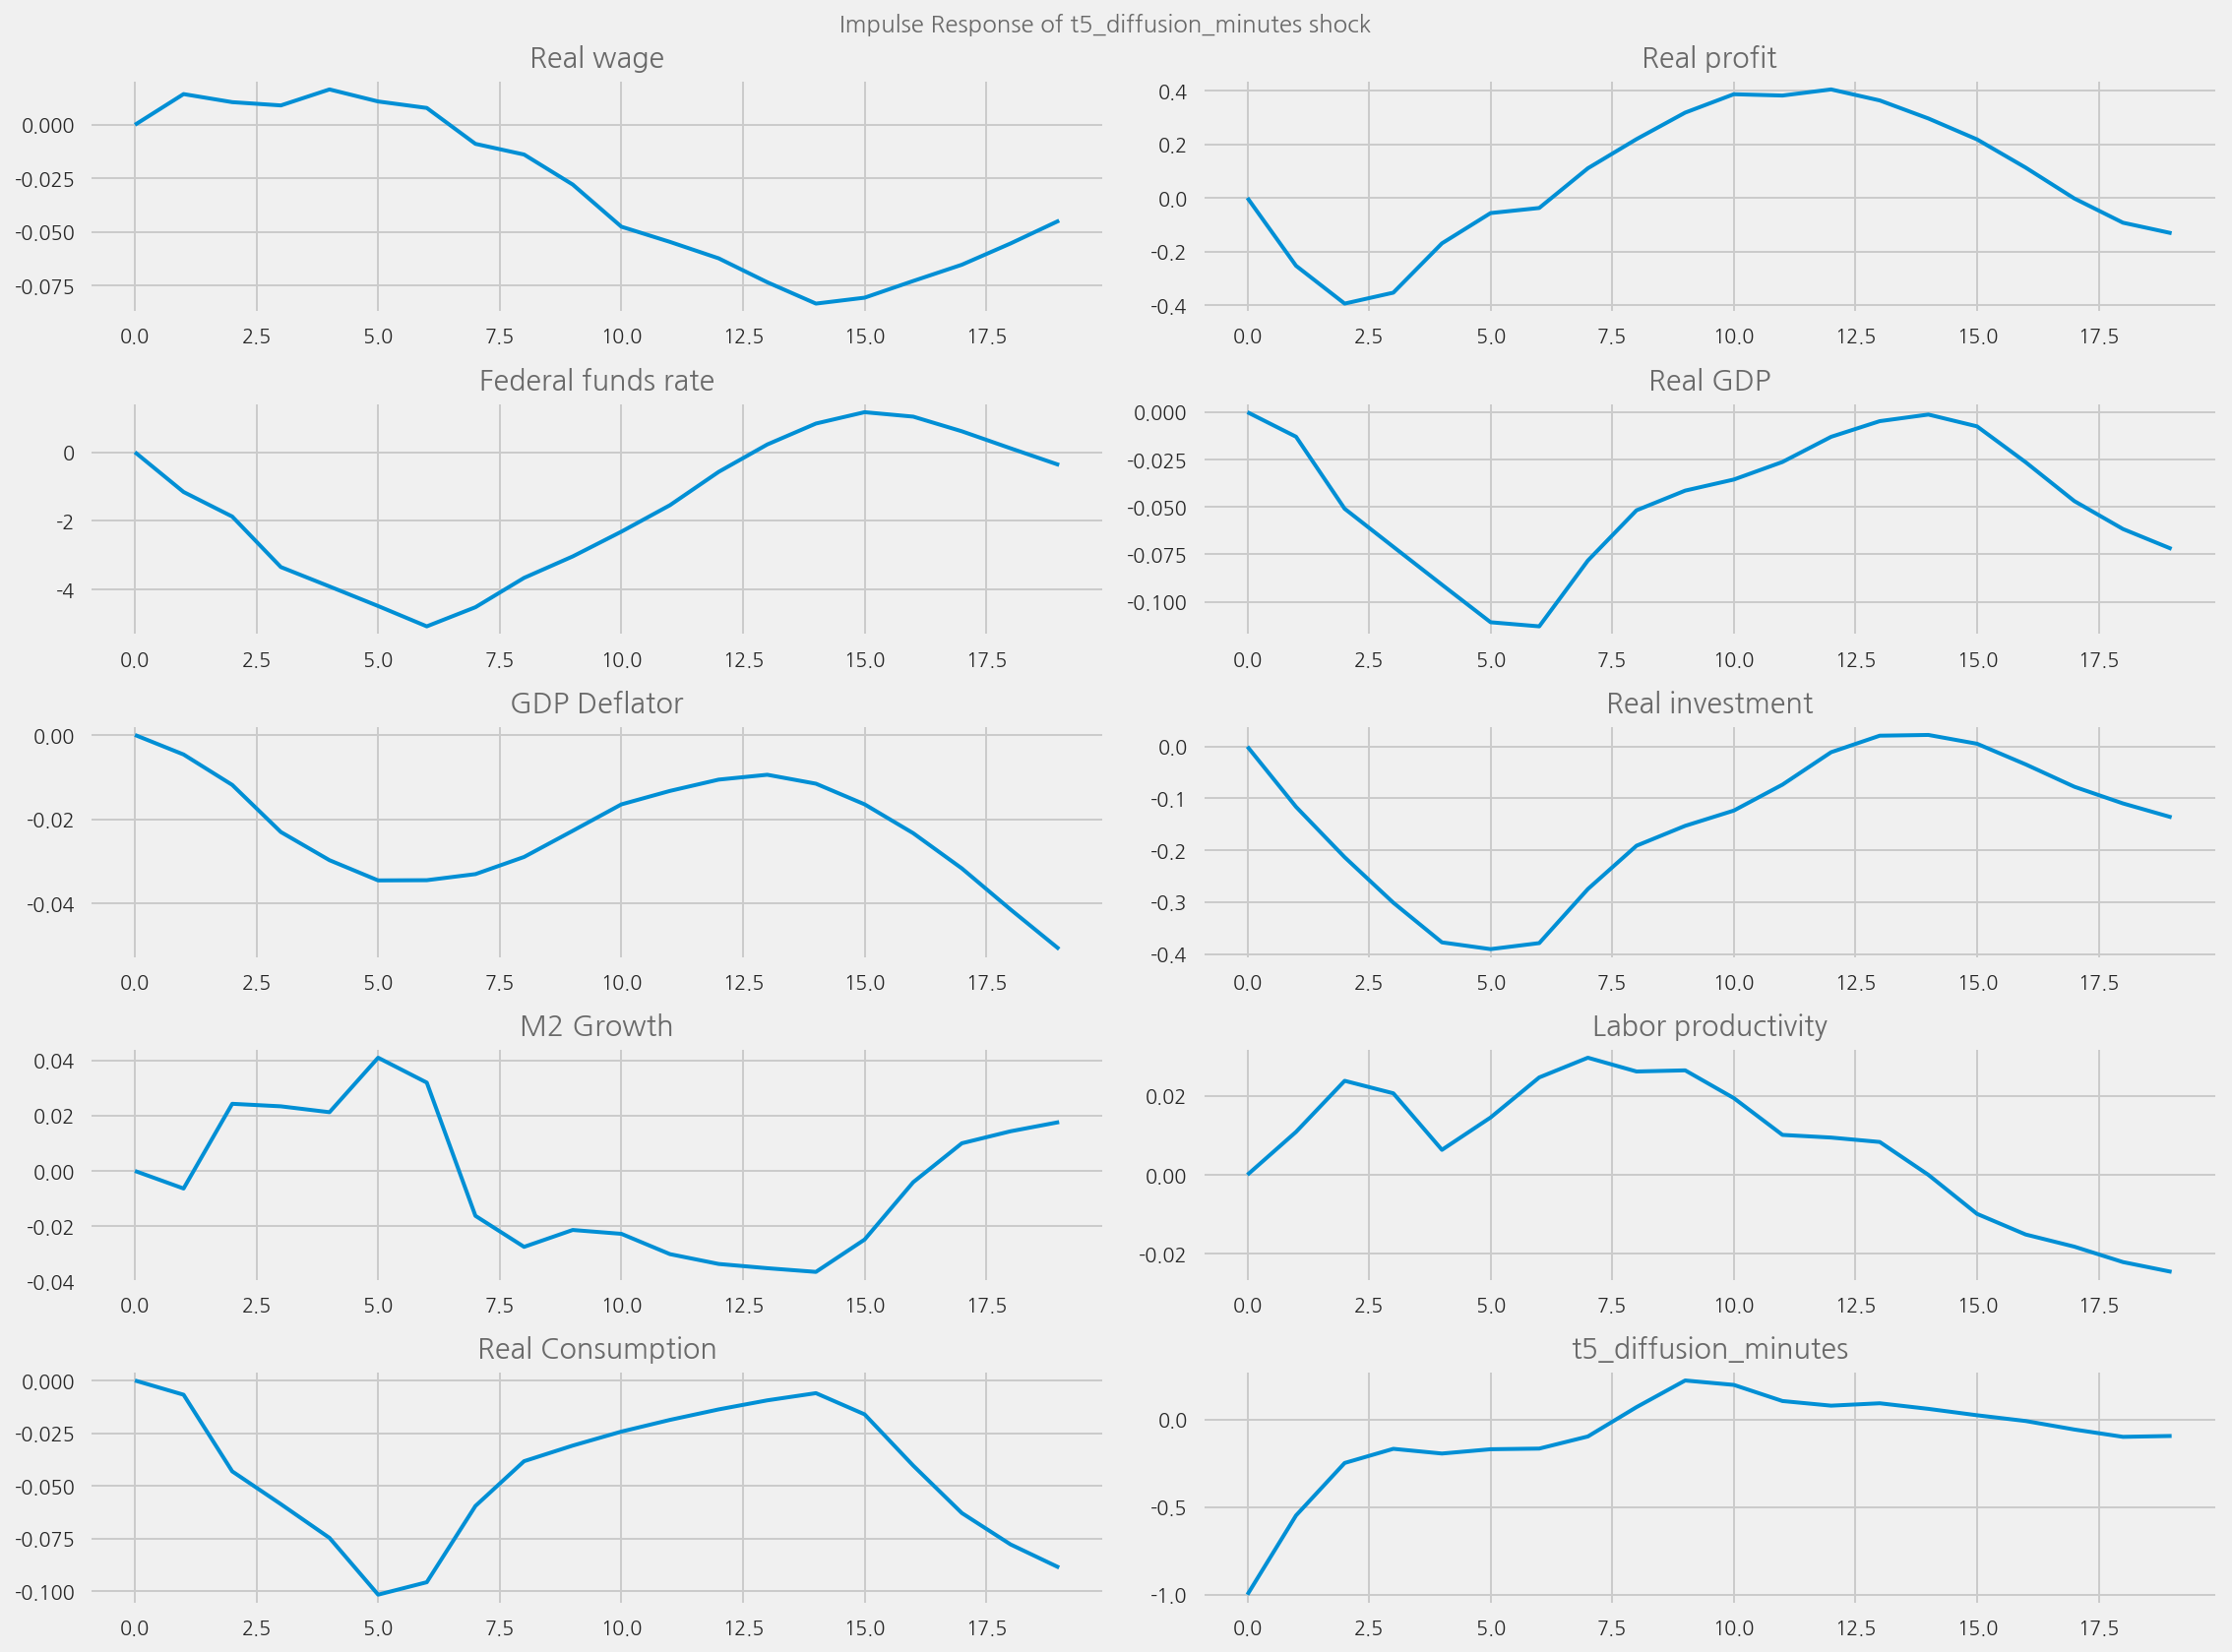

In [27]:
plot_irfs(tone_col="t5_diffusion_minutes")


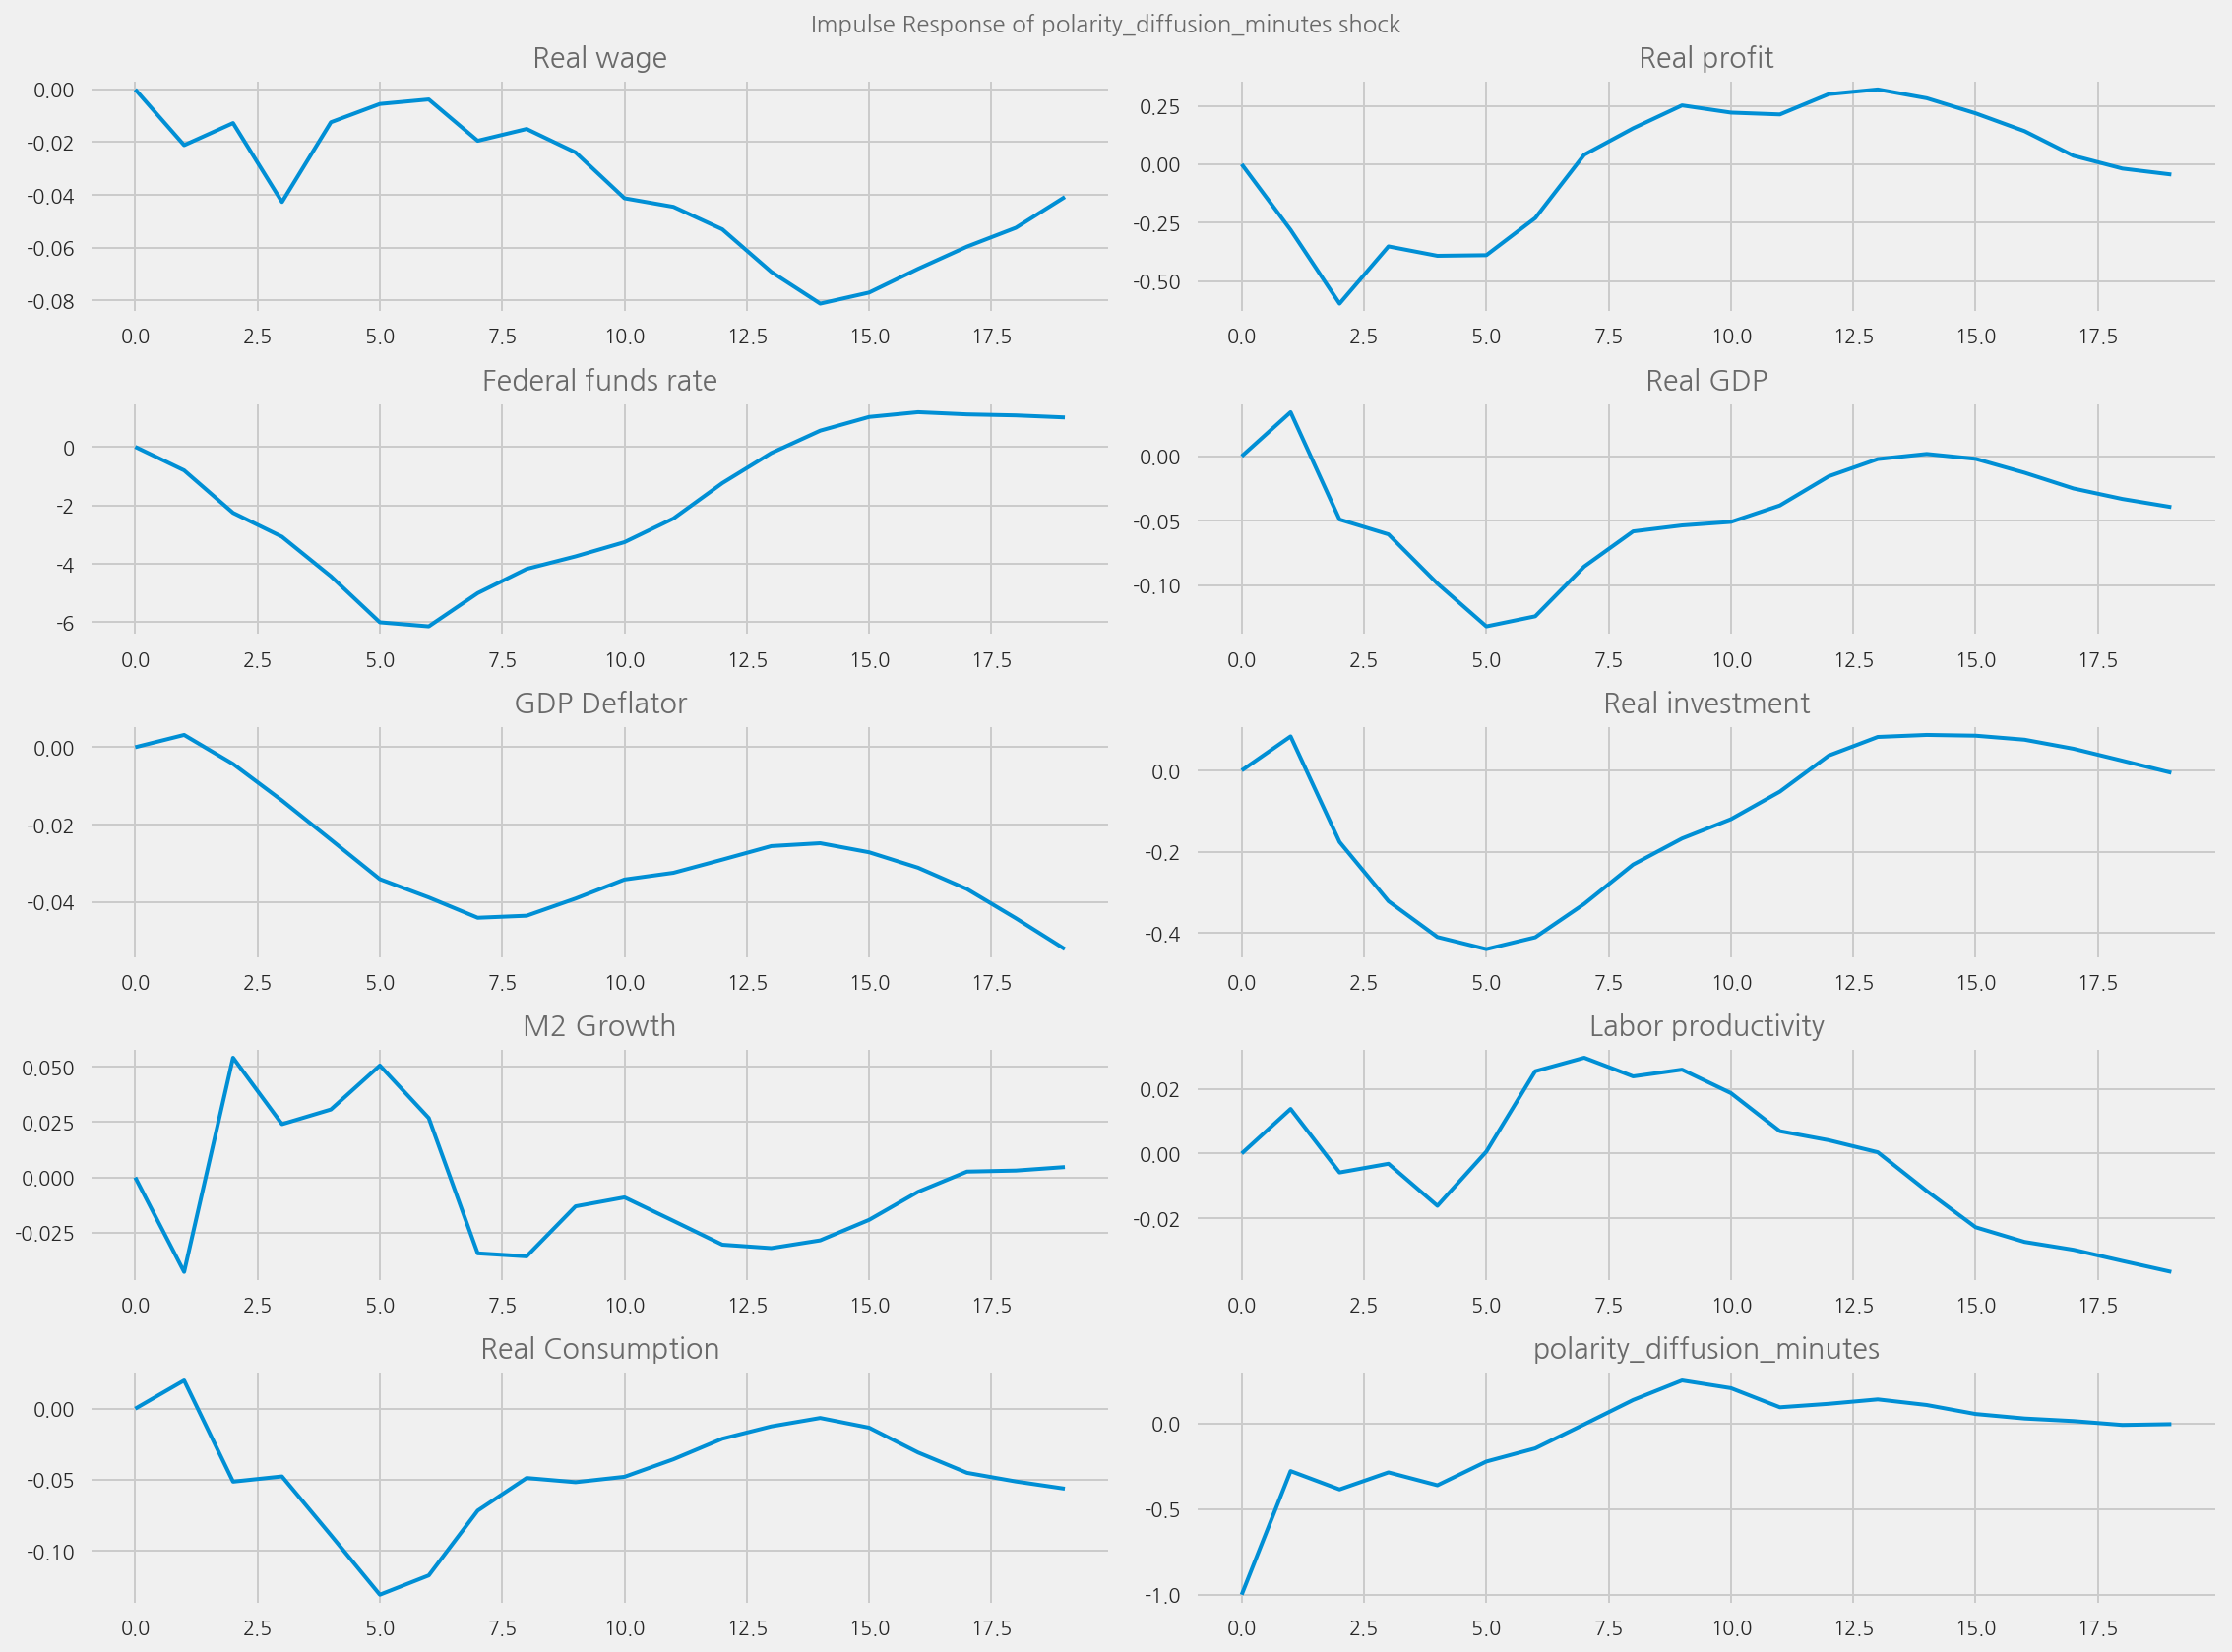

In [32]:
plot_irfs(tone_col="polarity_diffusion_minutes", shock_name=None)


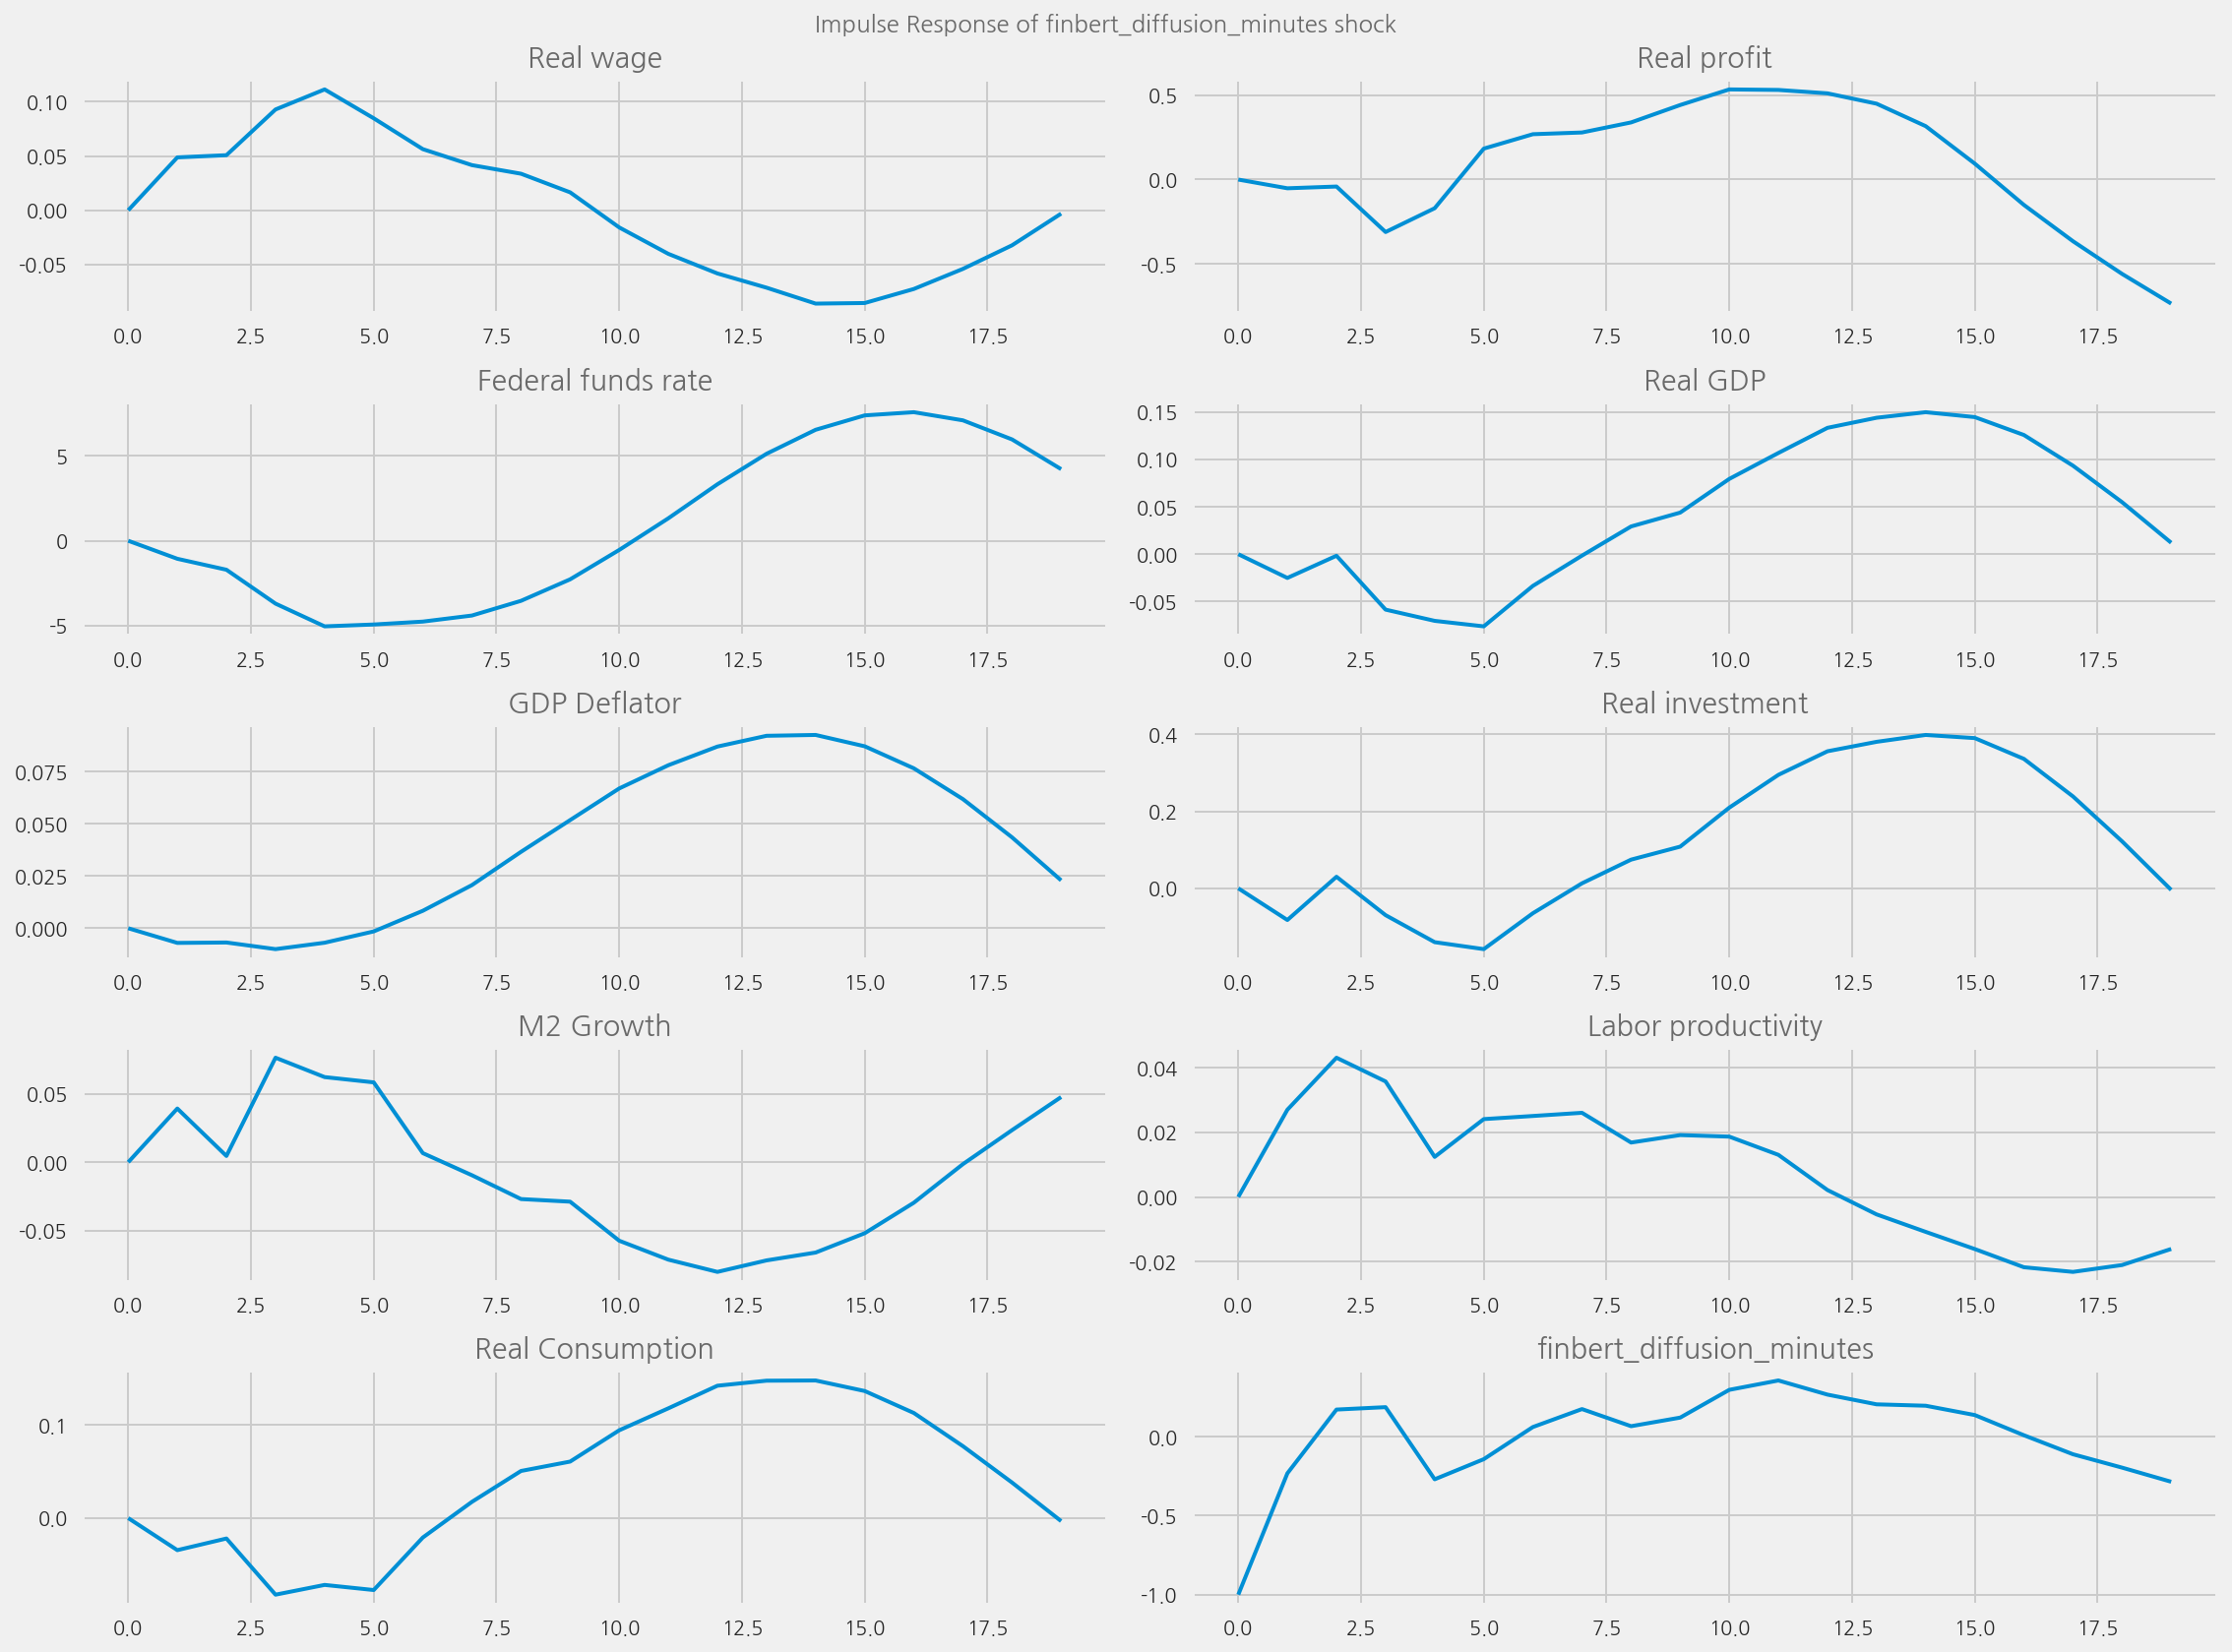

In [33]:
plot_irfs(tone_col="finbert_diffusion_minutes", shock_name=None)
